<h1><center>Knowledge Graph Construction</center></h1>

<b>Un graphe de connaissances est une manière de stocker des données issues d'une tâche d'extraction d'informations. De nombreuses implémentations de base des graphes de connaissances utilisent un concept appelé triplet, qui est un ensemble de trois éléments (un sujet, un prédicat et un objet) permettant de stocker des informations sur quelque chose.

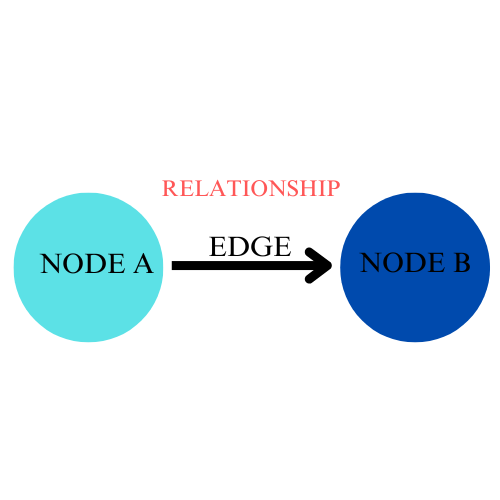

<B>Le nœud A et le nœud B sont ici deux entités différentes. Ces nœuds sont reliés par une arête qui représente la relation entre les deux nœuds. Il s'agit du plus petit graphe de connaissances que nous pouvons construire – également connu sous le nom de triplet. Les graphes de connaissances existent sous diverses formes et tailles.

**Importer les bibliothèques nécessaires**

In [4]:
import spacy
import numpy as np
import pandas as pd
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

**Lire et afficher les cinq premières lignes.**

In [5]:
data=pd.read_csv("comment.csv")
data.head()

,Post_Title,Post_Author,Post_URL,Comment_Author,Comment_Body,Comment_Score
0,An Islamic Caliphate in the modern era ?,Capitaine_snake,"https://www.reddit.com/r/MuslimLounge/comments/1gjoii4/an_islamic_caliphate_in_the_modern_era/?tl=fr#:~:text=Un%20califat%20islamique%20n'est,%C3%AAtre%20directement%20int%C3%A9gr%C3%A9s%20au%20go...",_Huge_Bush_,"Definitely don’t trust the Hadith if it is not sahih. \n\nAs for a Caliphate in the modern era, it’s definitely possible if Muslims finally wake up. I personally don’t see it happening until Allah...",14
1,An Islamic Caliphate in the modern era ?,Capitaine_snake,"https://www.reddit.com/r/MuslimLounge/comments/1gjoii4/an_islamic_caliphate_in_the_modern_era/?tl=fr#:~:text=Un%20califat%20islamique%20n'est,%C3%AAtre%20directement%20int%C3%A9gr%C3%A9s%20au%20go...",Chickenburger287,Too much evidence says it will happen. A common misconception and a cop out is also that it'll only happen after imam Mahdi but the evidence indicates otherwise.,5
2,An Islamic Caliphate in the modern era ?,Capitaine_snake,"https://www.reddit.com/r/MuslimLounge/comments/1gjoii4/an_islamic_caliphate_in_the_modern_era/?tl=fr#:~:text=Un%20califat%20islamique%20n'est,%C3%AAtre%20directement%20int%C3%A9gr%C3%A9s%20au%20go...",ancalagonxii,"\nThis is a weak hadith because it is mursal (disconnected). Yunus bin Maysarah bin Halbas, who narrated the hadith from the Prophet ﷺ, though a trustworthy; however, he is from the Tabi‘un, and t...",4
3,An Islamic Caliphate in the modern era ?,Capitaine_snake,"https://www.reddit.com/r/MuslimLounge/comments/1gjoii4/an_islamic_caliphate_in_the_modern_era/?tl=fr#:~:text=Un%20califat%20islamique%20n'est,%C3%AAtre%20directement%20int%C3%A9gr%C3%A9s%20au%20go...",samven582,We need a federation,3
4,An Islamic Caliphate in the modern era ?,Capitaine_snake,"https://www.reddit.com/r/MuslimLounge/comments/1gjoii4/an_islamic_caliphate_in_the_modern_era/?tl=fr#:~:text=Un%20califat%20islamique%20n'est,%C3%AAtre%20directement%20int%C3%A9gr%C3%A9s%20au%20go...",Adventurous-Cash2044,Can you cite the Hadith?,2


**Conserver la colonne qui contient les commentaires.**

In [6]:
dataset=data[['Comment_Author', 'Comment_Body']]

In [7]:
d_comment=dataset.dropna()
d_commentaire=pd.DataFrame(d_comment)
d_commentaire

,Comment_Author,Comment_Body
0,_Huge_Bush_,"Definitely don’t trust the Hadith if it is not sahih. \n\nAs for a Caliphate in the modern era, it’s definitely possible if Muslims finally wake up. I personally don’t see it happening until Allah..."
1,Chickenburger287,Too much evidence says it will happen. A common misconception and a cop out is also that it'll only happen after imam Mahdi but the evidence indicates otherwise.
2,ancalagonxii,"\nThis is a weak hadith because it is mursal (disconnected). Yunus bin Maysarah bin Halbas, who narrated the hadith from the Prophet ﷺ, though a trustworthy; however, he is from the Tabi‘un, and t..."
3,samven582,We need a federation
4,Adventurous-Cash2044,Can you cite the Hadith?
...,...,...
3486,makochi,"[From the facebook of the man in question](https://archive.fo/d6353):\n\n>Here is the truth about the knife, yes I had a knife in my pocket at the rally, I did not brandish it until I was leaving ..."
3487,TheNewPoetLawyerette,"Your ""I can choose to ignore hate speech"" example sidesteps Spez's example of how allowing hate speech at all suppresses speech from minorities that you keep bringing up, and my point that white s..."
3491,IBiteYou,"Well, who ARE these people saying this? I'd love to address it."
3492,IBiteYou,"I don't think that Facebook entry helps your case that he was some KKK guy.\n\n> and brandished it people as a show of force against ""radical muslims,"" \n\nWho wanted the statue down because they ..."


<b>Extraction des entités</b>


In [8]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################
    return [ent1.strip(), ent2.strip()]


<b>Relations Extraction

In [9]:
def get_relation(sent):
    # Analyser la phrase avec SpaCy
    doc = nlp(sent)

    # Créer un objet Matcher
    matcher = Matcher(nlp.vocab)

    # Définir un motif pour la relation
    pattern = [
        {'DEP': 'ROOT'},
        {'DEP': 'prep', 'OP': "?"},  # préposition optionnelle
        {'DEP': 'agent', 'OP': "?"},  # agent optionnel
        {'POS': 'ADJ', 'OP': "?"}    # adjectif optionnel
    ]

    # Ajouter le motif au matcher
    matcher.add("matching_1", [pattern])  # Passer la liste de motifs directement

    # Trouver les correspondances
    matches = matcher(doc)

    if not matches:
        return "Aucune correspondance trouvée"

    # Récupérer la dernière correspondance
    k = len(matches) - 1

    # Extraire le texte correspondant à la correspondance
    span = doc[matches[k][1]:matches[k][2]]

    return span.text

In [10]:
entity_pairs = []

# Parcours des commentaires
for i in tqdm(range(len(d_commentaire))):
    # Extraire l'auteur et le corps du commentaire
    author = d_commentaire['Comment_Author'].iloc[i]
    comment = d_commentaire['Comment_Body'].iloc[i]

    # Extraire les entités du commentaire
    entities = get_entities(comment)  # Vous devez définir cette fonction
    relation = get_relation(comment)

    # Ajouter l'auteur et les entités à la liste
    entity_pairs.append((author, entities,relation))

# Afficher les premières paires d'entités extraites
print(entity_pairs[:5])

100%|██████████| 2998/2998 [01:47<00:00, 27.93it/s]

[('_Huge_Bush_', ['around  what', 'time'], 'see'), ('Chickenburger287', ['only imam evidence', 'only imam Mahdi'], 'is'), ('ancalagonxii', ['well  Islam', '_'], 'QA](https://islamqa.info'), ('samven582', ['We', 'federation'], 'need'), ('Adventurous-Cash2044', ['you', 'Hadith'], 'cite')]


In [11]:
print(entity_pairs[:10])

[('_Huge_Bush_', ['around  what', 'time'], 'see'), ('Chickenburger287', ['only imam evidence', 'only imam Mahdi'], 'is'), ('ancalagonxii', ['well  Islam', '_'], 'QA](https://islamqa.info'), ('samven582', ['We', 'federation'], 'need'), ('Adventurous-Cash2044', ['you', 'Hadith'], 'cite'), ('Mission_Article483', ['caliphate', 'Jerusalem'], 'are sahih'), ('yasinburak15', ['modern  caliphate', 'Muslim  nations'], 'needs'), ('Capitaine_snake', ['guided  we', 'matter'], 'were'), ('Capitaine_snake', ['mahdi', 'established  Caliphate'], 'suppose'), ('Capitaine_snake', ['I', 'thanks clarification brother'], 'know')]


In [12]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

relation = [i[2] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [13]:
kg_df.dropna()

,source,target,edge
0,_Huge_Bush_,"[around what, time]",see
1,Chickenburger287,"[only imam evidence, only imam Mahdi]",is
2,ancalagonxii,"[well Islam, _]",QA](https://islamqa.info
3,samven582,"[We, federation]",need
4,Adventurous-Cash2044,"[you, Hadith]",cite
...,...,...,...
2993,makochi,"[i, good faith]",know
2994,TheNewPoetLawyerette,"[black people, nature]",'s
2995,IBiteYou,"[I, it]",love
2996,IBiteYou,"[so we, it]",'s


In [14]:
entity_pairs[1][2]

'is'

In [15]:
# Vérifier les types dans les colonnes 'source' et 'target'
print(kg_df["source"].apply(type).value_counts())
print(kg_df["target"].apply(type).value_counts())

# Si des listes sont présentes, les convertir en chaînes de caractères
kg_df["source"] = kg_df["source"].apply(lambda x: str(x) if isinstance(x, list) else x)
kg_df["target"] = kg_df["target"].apply(lambda x: str(x) if isinstance(x, list) else x)

# Ensuite, recréer le graphe
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())


source
<class 'str'>    2998
Name: count, dtype: int64
target
<class 'list'>    2998
Name: count, dtype: int64


<h1>Build Knowledge Graph

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129396 (\N{FACE WITH UNEVEN EYES AND WAVY MOUTH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


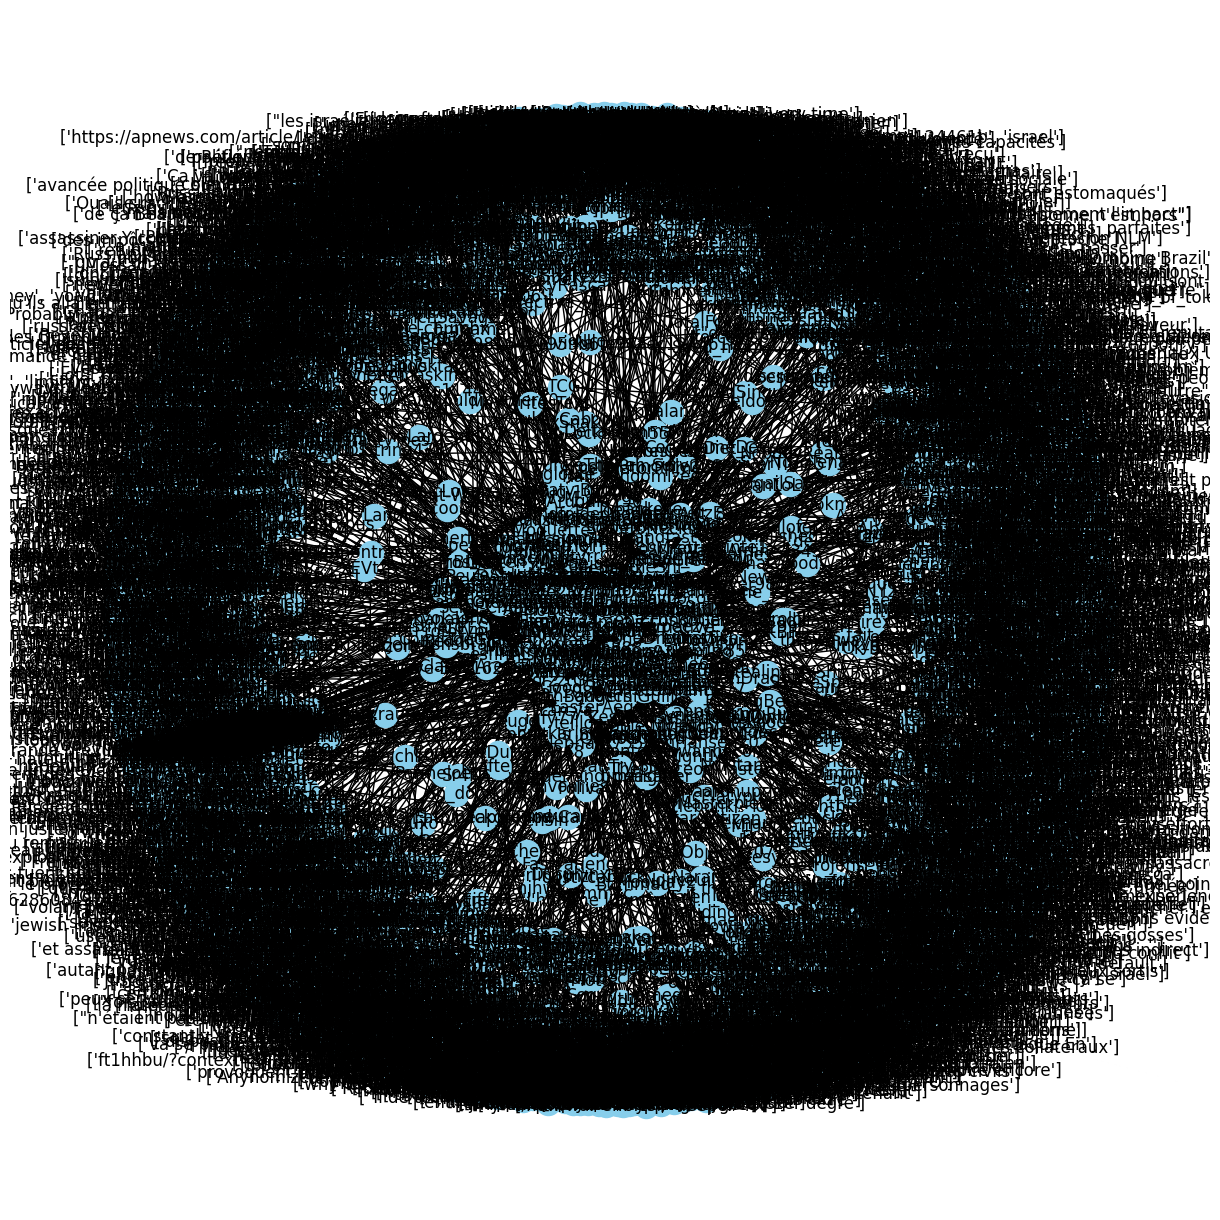

In [16]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

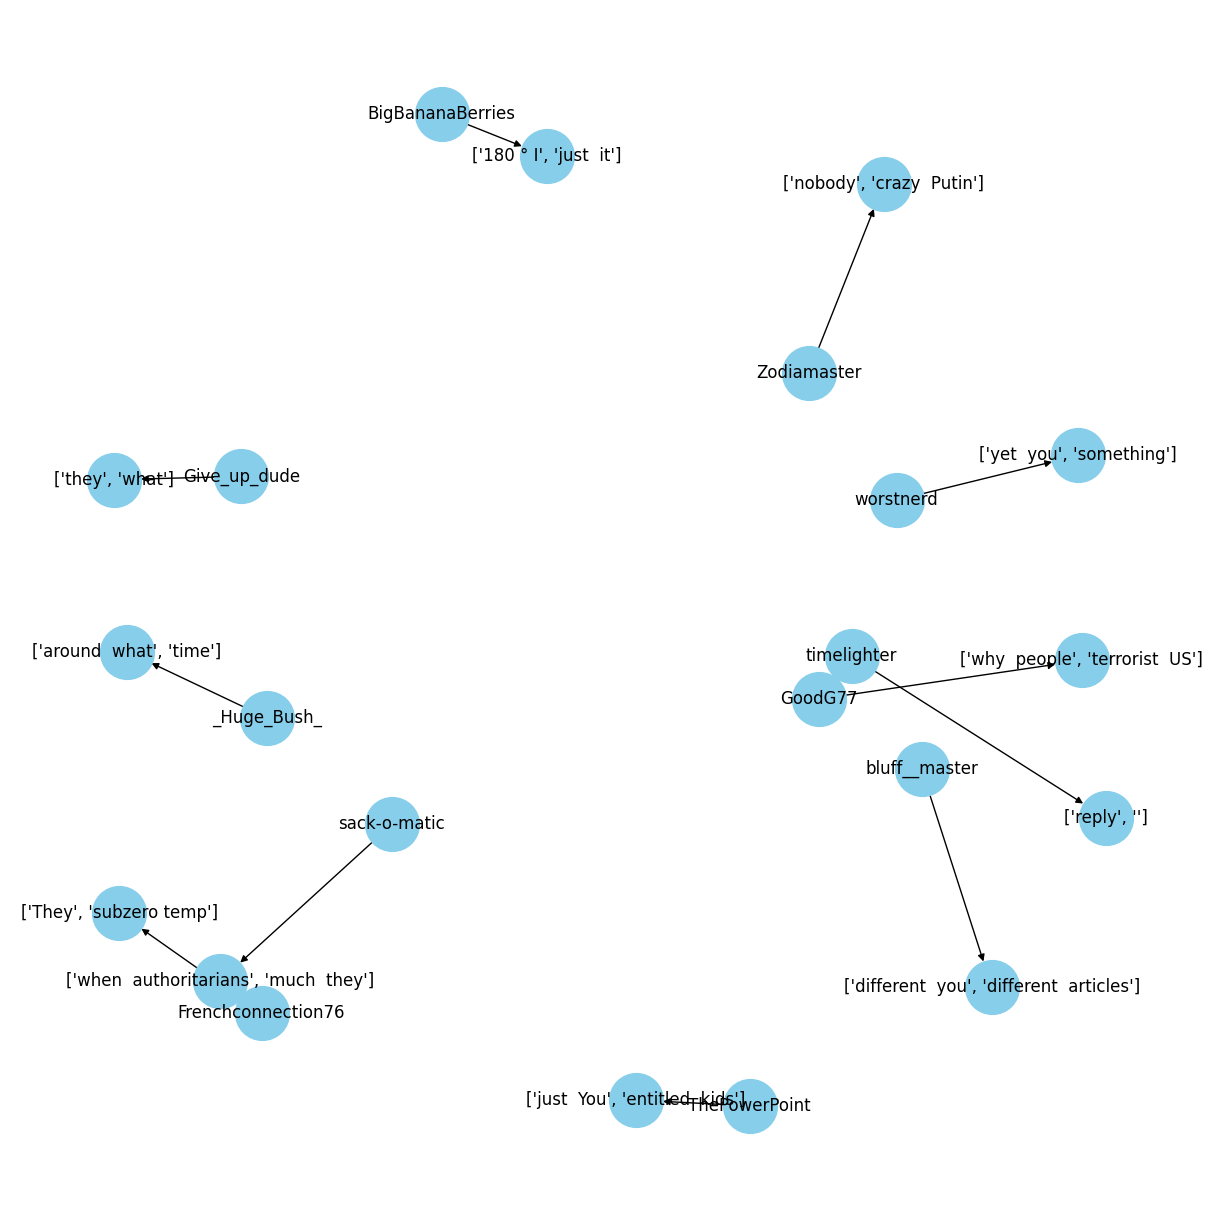

In [17]:
Ga=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="see"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(Ga, k = 0.5) # k regulates the distance between nodes
nx.draw(Ga, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

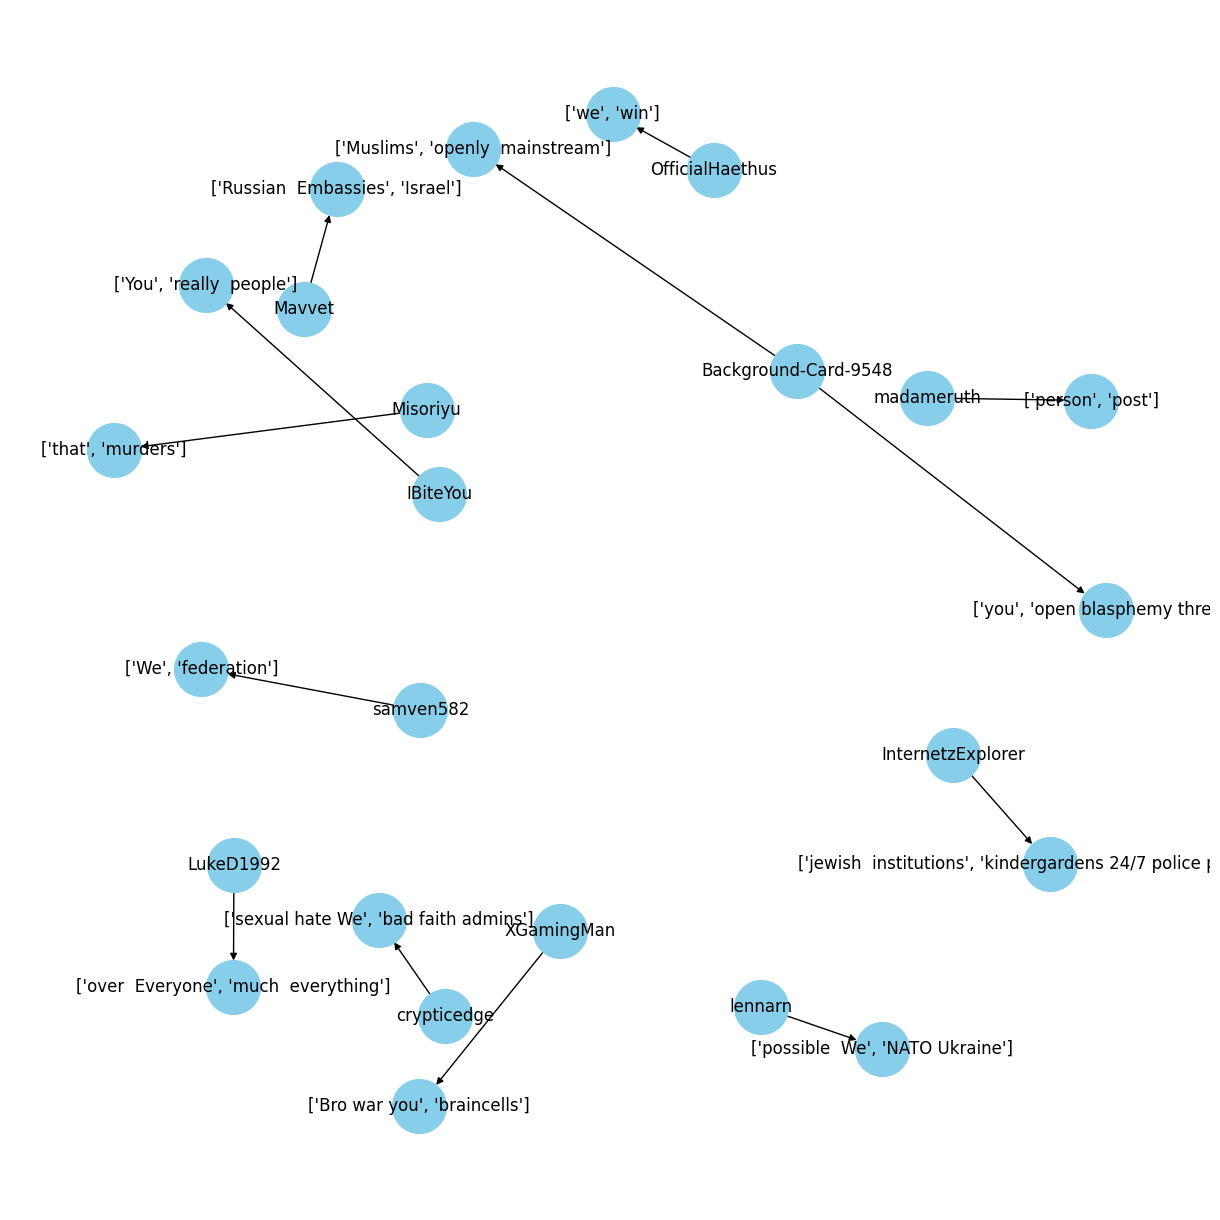

In [18]:
Gn=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="need"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(Gn, k = 0.5) # k regulates the distance between nodes
nx.draw(Gn, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<h1>Mesures de Centralité</h1>

**1. Centralité de Degré**

In [19]:
degree_centrality = nx.degree_centrality(G)
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1],reverse=True)
print("Top 5 noeuds par centralité de degré :", sorted_nodes[:5])

Top 5 noeuds par centralité de degré : [("['', '']", 0.06349589570255915), ('TheNewPoetLawyerette', 0.01110574601641719), ('IBiteYou', 0.010140028971511346), ('aasfourasfar', 0.008932882665379043), ('PsyX99', 0.007242877836793819)]


<b>Interprétation</b>

<b>1. **["", ""]** :</b> Ce nœud semble être une valeur vide ou mal formatée, ce qui pourrait indiquer une anomalie ou une absence de données.<br>
<b>2. **TheNewPoetLawyerette** :</b> C'est un nœud qui a une centralité de degré relativement élevée, ce qui signifie qu'il est connecté à plusieurs autres nœuds dans le graphe, suggérant qu'il joue un rôle important dans le réseau.<br>
<b>3. **IBiteYou** :</b> Ce nœud est également relativement bien connecté, indiquant qu'il a une certaine influence ou importance dans le contexte des relations analysées.<br>
<b>4. **aasfourasfar** : </b>Moins central que les deux précédents, mais il reste un nœud significatif dans le réseau avec une centralité modérée.<br>
<b>5. **PsyX99** :</b> Ce nœud, bien qu'ayant une centralité plus faible que les autres, est toujours notable dans le réseau pour ses connexions.<br>
<b>
En résumé, ces nœuds représentent les entités les plus connectées, jouant potentiellement des rôles influents ou centraux dans le graphe de connaissances que vous avez construit.</b>

<b>2. Centralité d'Intermédiarité (Betweenness)

In [20]:
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)
print("Top 5 nœuds par centralité d'intermédiarité :", sorted_betweenness[:5])

Top 5 nœuds par centralité d'intermédiarité : [('_Huge_Bush_', 0.0), ("['around  what', 'time']", 0.0), ('Chickenburger287', 0.0), ("['only imam evidence', 'only imam Mahdi']", 0.0), ('ancalagonxii', 0.0)]


<b>Interprétation</b>

<b>L'interprétation des cinq premiers nœuds par centralité d'intermédiarité montre que ces nœuds ne jouent aucun rôle d'intermédiaire dans le graphe, c'est-à-dire qu'ils n'agissent pas comme des "ponts" entre d'autres nœuds

<b>3. Centralité de Proximité (Closeness)

In [21]:
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1],reverse=True)
print("Top 5 nœuds par centralité de proximité :", sorted_closeness[:5])

Top 5 nœuds par centralité de proximité : [("['', '']", 0.0521487204249155), ("['you', '']", 0.0021728633510381457), ("['That', '']", 0.0016900048285852245), ("['you', 'what']", 0.0012071463061323032), ("['they', '']", 0.0012071463061323032)]


<b>Interprétation</b>

<b>
1. **["", ""]** :</b> Ce nœud semble représenter une valeur vide ou mal formatée, mais malgré cela, il a une centralité de proximité modérée (0.052), ce qui suggère qu'il est relativement proche d'autres nœuds, mais son rôle dans le réseau n'est pas clair en raison de sa forme.<br>

<b>2. **["you", ""]** :</b> Ce nœud a une centralité de proximité faible (0.002), ce qui signifie qu'il est un peu plus éloigné des autres nœuds, mais il reste connecté à une partie importante du graphe. Cela pourrait être un nœud qui apparaît fréquemment dans les interactions mais n'a pas une forte centralité par rapport aux autres.<br>
<b>3. **["That", ""]** :</b> De même, ce nœud a une centralité faible (0.0017). Il semble jouer un rôle marginal mais toujours présent dans les connexions du graphe.<br>

<b>4. **["you", "what"]** : </b>Ce nœud, avec une centralité très faible (0.0012), est également un nœud isolé, mais il a un rôle dans la structure de proximité du graphe, bien qu'il soit éloigné des autres.<br>

<b>5. **["they", ""]** :</b> Ce nœud, avec une centralité de proximité identique à celle de ["you", "what"] (0.0012), est également un élément relativement distant dans le réseau, sans être un point clé de connexion.

<b>4. Centralité de Vecteur Propre (Eigenvector)

In [22]:
# Convertir MultiDiGraph en DiGraph
G_simple = nx.DiGraph(G)
# Calculer la centralité du vecteur propre
eigenvector_centrality = nx.eigenvector_centrality(G_simple, max_iter=1000)
# Trier les résultats par centralité décroissante
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True)
# Afficher les 10 premiers nœuds par centralité de vecteur propre
print("Top 5 nœuds par centralité de vecteur propre :", sorted_eigenvector[:5])

Top 5 nœuds par centralité de vecteur propre : [("['', '']", 0.9687418046362366), ("['you', '']", 0.04042838734196678), ("['That', '']", 0.031459175580669504), ("['you', 'what']", 0.02248996381937232), ("['they', '']", 0.02248996381937232)]


<b>Interprétation</b>

1. **["", ""]** : Ce nœud a une centralité de vecteur propre très élevée (0.968), ce qui suggère qu'il est extrêmement influent dans le réseau, bien qu'il semble être une valeur vide ou mal formatée. Cela pourrait signifier que ce nœud est très connecté à des nœuds importants dans le réseau, bien que sa forme ne soit pas claire.

2. **["you", ""]** : Ce nœud a une centralité de vecteur propre relativement faible (0.040), ce qui signifie qu'il est moins influent par rapport aux autres nœuds du réseau, mais il reste un nœud significatif qui interagit avec des entités importantes.

3. **["That", ""]** : Ce nœud a une centralité modérée (0.031), suggérant qu'il joue un rôle modéré dans le réseau. Il est connecté à certains nœuds influents, mais son impact global est inférieur à celui de ["", ""] et ["you", ""].

4. **["you", "what"]** : Avec une centralité de vecteur propre de 0.022, ce nœud est moins central dans le graphe, indiquant qu'il a moins d'influence. Cependant, il est connecté à d'autres nœuds avec un certain niveau d'importance dans le réseau.

5. **["they", ""]** : Ce nœud a une centralité de vecteur propre identique à celle de ["you", "what"] (0.022), ce qui signifie qu'il est aussi relativement peu influent, bien qu'il fasse partie de certaines connexions importantes dans le réseau.

<b>Calcul de PageRank

In [23]:
pagerank_centrality = nx.pagerank(G, alpha=0.85)
print("PageRank :", pagerank_centrality)

PageRank : {'_Huge_Bush_': 0.0001846794775925407, "['around  what', 'time']": 0.0003422065898219888, 'Chickenburger287': 0.0001846794775925407, "['only imam evidence', 'only imam Mahdi']": 0.00026344303370726477, 'ancalagonxii': 0.0001846794775925407, "['well  Islam', '_']": 0.0003422065898219888, 'samven582': 0.0001846794775925407, "['We', 'federation']": 0.0003422065898219888, 'Adventurous-Cash2044': 0.0001846794775925407, "['you', 'Hadith']": 0.0003422065898219888, 'Mission_Article483': 0.0001846794775925407, "['caliphate', 'Jerusalem']": 0.0003422065898219888, 'yasinburak15': 0.0001846794775925407, "['modern  caliphate', 'Muslim  nations']": 0.0003422065898219888, 'Capitaine_snake': 0.0001846794775925407, "['guided  we', 'matter']": 0.00021618490003843033, "['mahdi', 'established  Caliphate']": 0.00021618490003843033, "['I', 'thanks clarification brother']": 0.00021618490003843033, "['modern nation state interpretation', 'islam']": 0.00021618490003843033, "['Allah', 'world']": 0.00

<h1>Algorithmique de la Méthode de Louvain</h1>

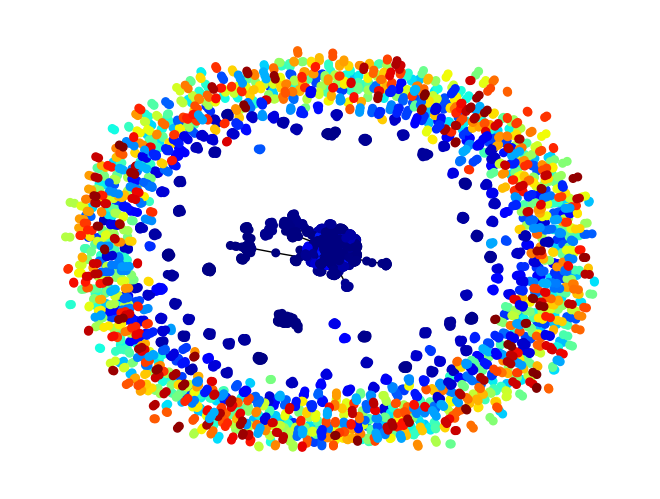

In [28]:
# Convertir en graphe non dirigé si nécessaire
G_undirected = G.to_undirected()

# Détection des communautés avec NetworkX
communities = greedy_modularity_communities(G_undirected)

# Créer une partition sous forme de dictionnaire
partition = {node: i for i, community in enumerate(communities) for node in community}

# Visualisation
pos = nx.spring_layout(G_undirected)
nx.draw(
    G_undirected,
    pos,
    node_size=30,
    cmap=plt.cm.jet,
    node_color=[partition[node] for node in G_undirected.nodes],
    edge_cmap=plt.cm.Blues,
    with_labels=False
)
plt.show()

### Interprétation

- **Points colorés** :  
  Chaque nœud (point) du graphe est coloré selon la communauté à laquelle il appartient. Les couleurs différentes représentent les différentes communautés détectées.

- **Disposition** :  
  La disposition est déterminée par l'algorithme `spring_layout`, qui place les nœuds de manière à minimiser les chevauchements tout en représentant les relations dans le graphe (les forces de connexion).

- **Groupements visibles** :  
  - Les nœuds regroupés au centre représentent probablement une communauté dense avec beaucoup de connexions internes.  
  - Les nœuds sur les bords sont dispersés, formant plusieurs petites communautés ou des sous-structures.

- **Répartition des communautés** :  
  - Le code utilise la modularité pour diviser les nœuds en communautés maximisant la cohésion interne des groupes.  
  - Chaque communauté est assignée à un index, utilisé pour la coloration des nœuds.  

In [29]:
communities = greedy_modularity_communities(G)

# Calcul de la modularité avec NetworkX
modularity = nx.community.modularity(G, communities)

# Afficher la modularité
print(f"Modularité de la partition : {modularity}")

Modularité de la partition : 0.9645806788692876


<b>En résumé, une modularité de 0.9465 reflète une partition de très bonne qualité, où les communautés sont distinctes et bien structurées